<a href="https://colab.research.google.com/github/Caivil/Classification_using_Random_Forest/blob/main/Random_Forest_MOA_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
#Imports
# Data Handling
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize, MinMaxScaler

# Feature Selection
from sklearn.feature_selection import mutual_info_classif

# Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

# Performance Metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    roc_auc_score, accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score
)

from mlxtend.evaluate import bias_variance_decomp
from sklearn.model_selection import LeaveOneOut, StratifiedKFold

In [26]:
#Load Data
pca_scores = pd.read_csv("pca_scores_ml.csv")
print(pca_scores.head())

                      Unnamed: 0        PC1        PC2        PC3        PC4  \
0                        control -26.495706   0.388818  -7.104919   6.508608   
1                      control.1 -25.636092  -0.195467 -12.305153   4.207569   
2                     DNA.damage   5.395150  46.115786  23.012664 -48.889795   
3  cell.wall.synthesis.inhibitor -27.188580   2.462730 -14.095076   4.654185   
4              Protein.synthesis  68.861608  15.512617  -1.482995   7.870280   

         PC5       PC6        PC7       PC8        PC9  ...      PC48  \
0 -24.036547  4.268672 -10.955927 -6.388247   6.392293  ...  0.459463   
1 -24.940074  1.178234  -9.594169 -7.646461   7.359083  ...  1.229706   
2  -8.692369  5.234416   6.087924  4.979285  13.101967  ...  0.164984   
3 -25.968652 -0.386679 -10.418556 -8.221158   6.497961  ...  0.762630   
4   1.335467  8.872081 -14.516351 -1.928519   7.291846  ...  0.716185   

       PC49      PC50      PC51       PC52      PC53      PC54      PC55  \
0  1

In [27]:
#Clean Data
pca_scores = pca_scores.drop(pca_scores.columns[16:], axis=1)
pca_scores.columns.values[0] = 'MOA'
pca_scores['MOA'] = (
    pca_scores['MOA']
    .str.replace(r'\.\d+$', '', regex=True)
    .str.replace('.', ' ')
    .str.strip()
)

MOA
cell wall synthesis inhibitor     15
DNA replication inhibitor         12
Protein synthesis                  9
control                            6
Membrane perturbation              6
DNA damage                         3
new hit                            3
Folic Acid synthesis inhibitor     3
Name: count, dtype: int64


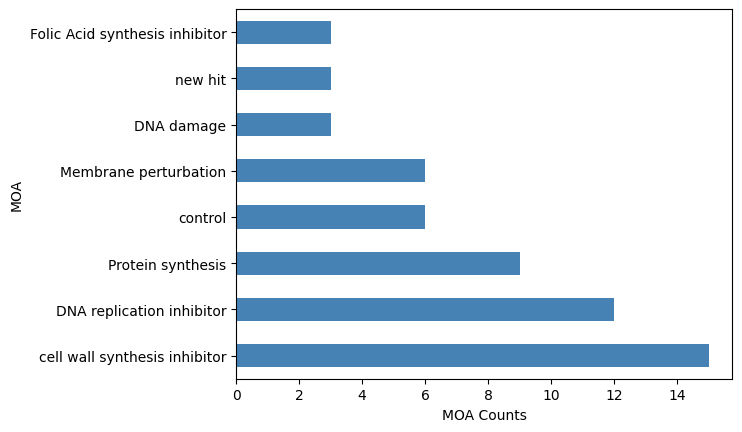

In [28]:
#Visualize MOA counts
print(pca_scores["MOA"].value_counts())
pca_scores["MOA"].value_counts().plot.barh(
    xlabel="MOA Counts", ylabel="MOA", color="steelblue")
plt.show()

In [29]:
#Train/Test Split
X = pca_scores.drop('MOA', axis=1)
y = pca_scores['MOA']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

In [30]:
#Random Forest Model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

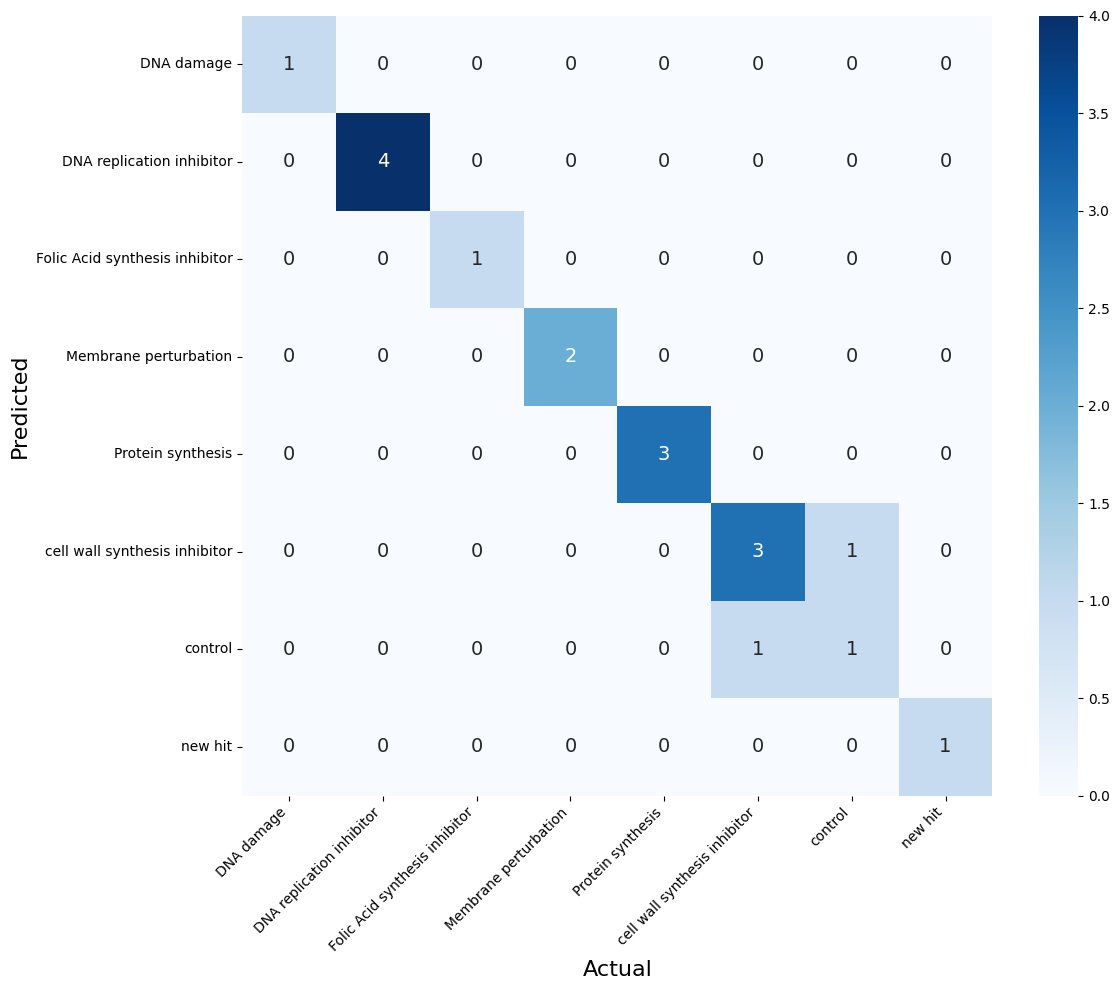

In [31]:
#Confusion Matrix
classes = sorted(y_test.unique())
cm = confusion_matrix(y_test, y_pred, labels=classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            annot_kws={"size": 14},
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Actual", fontsize=16)
plt.ylabel("Predicted", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [32]:
#Classification Report
report = classification_report(y_test, y_pred, output_dict=True)
print(f"Balanced Accuracy: {report['accuracy']:.4f}")
print(f"Macro Precision: {report['macro avg']['precision']:.4f}")
print(f"Macro Recall: {report['macro avg']['recall']:.4f}")
print(f"Macro F1: {report['macro avg']['f1-score']:.4f}")

Balanced Accuracy: 0.8889
Macro Precision: 0.9062
Macro Recall: 0.9062
Macro F1: 0.9062


In [39]:
#Bias-Variance (Original Model)

X_train_np, X_test_np = X_train.values, X_test.values
y_train_np, y_test_np = y_train.values, y_test.values
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_np)
y_test_enc = le.transform(y_test_np)
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
    rf, X_train_np, y_train_enc, X_test_np, y_test_enc,
    loss='0-1_loss', random_seed=42, num_rounds=1000)
print(f'Expected Loss: {round(avg_expected_loss, 4)}')
print(f'Bias: {round(avg_bias, 4)}')
print(f'Variance: {round(avg_var, 4)}')

Expected Loss: 0.3024
Bias: 0.1667
Variance: 0.2679


In [20]:
#Leave-One-Out CV
loo = LeaveOneOut()
y_true_loocv, y_pred_loocv = [], []
for train_index, test_index in loo.split(X_train):
    X_train_loo, X_test_loo = X_train[train_index], X_train[test_index]
    y_train_loo, y_test_loo = y_train[train_index], y_train[test_index]
    rf.fit(X_train_loo, y_train_loo)
    y_hat = rf.predict(X_test_loo)
    y_true_loocv.append(y_test_loo[0])
    y_pred_loocv.append(y_hat[0])
balanced_acc = balanced_accuracy_score(y_true_loocv, y_pred_loocv)
macro_precision = precision_score(y_true_loocv, y_pred_loocv, average='macro', zero_division=0)
macro_recall = recall_score(y_true_loocv, y_pred_loocv, average='macro', zero_division=0)
macro_f1 = f1_score(y_true_loocv, y_pred_loocv, average='macro', zero_division=0)
print("LOOCV:")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1: {macro_f1:.4f}")

LOOCV:
Balanced Accuracy: 0.6974
Macro Precision: 0.8708
Macro Recall: 0.6974
Macro F1: 0.7493


In [43]:
#Bias-Variance (Holdout Test Set)
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
    rf, X_train.values, y_train_enc, X_test.values, y_test_enc,
    loss='0-1_loss', random_seed=42, num_rounds=1000)
print("Bias-Variance Decomposition:")
print(f"Expected Loss: {avg_expected_loss:.4f}")
print(f"Bias: {avg_bias:.4f}")
print(f"Variance: {avg_var:.4f}")

Bias-Variance Decomposition:
Expected Loss: 0.3024
Bias: 0.1667
Variance: 0.2679


In [22]:
#Stratified K-Fold
X_array, y_array = X.values, y.values
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rf = RandomForestClassifier(random_state=42)

balanced_acc_scores = []
macro_precision_scores = []
macro_recall_scores = []
macro_f1_scores = []

for train_idx, test_idx in skf.split(X_array, y_array):
    X_train, X_test = X_array[train_idx], X_array[test_idx]
    y_train, y_test = y_array[train_idx], y_array[test_idx]
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    balanced_acc_scores.append(balanced_accuracy_score(y_test, y_pred))
    macro_precision_scores.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
    macro_recall_scores.append(recall_score(y_test, y_pred, average='macro', zero_division=0))
    macro_f1_scores.append(f1_score(y_test, y_pred, average='macro', zero_division=0))

print("\nK-Fold Cross-Validation Results:")
print(f"Mean Balanced Accuracy: {np.mean(balanced_acc_scores):.4f}")
print(f"Mean Macro Precision: {np.mean(macro_precision_scores):.4f}")
print(f"Mean Macro Recall: {np.mean(macro_recall_scores):.4f}")
print(f"Mean Macro F1: {np.mean(macro_f1_scores):.4f}")


K-Fold Cross-Validation Results:
Mean Balanced Accuracy: 0.7042
Mean Macro Precision: 0.7049
Mean Macro Recall: 0.7042
Mean Macro F1: 0.6885


In [21]:
# The best model is the Stratified K-Fold Random Forest.
# It achieved consistently high performance metrics across folds,
# while maintaining a good balance between variance and bias.